In [1]:
import os
import pandas as pd
from datetime import datetime
from pymongo import MongoClient
from bson import ObjectId
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from src.model import Model
from src.mtg_df_prep import load_color_data
from src.helpers import generate_flow_df, plot_conf_matrix

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array



In [2]:
client = MongoClient('192.168.0.209', 27017)
db = client['capstone_3']
model_db = db['models']

In [3]:
cards = load_color_data(mono=True, land=False)
noland = cards[cards.set_type.isin(['starter', 'core', 'expansions'])]
cards = load_color_data(mono=True, colorless=False)
nocolorless = cards[cards.set_type.isin(['starter', 'core', 'expansions'])]
cards = load_color_data(mono=True)
all_colors = cards[cards.set_type.isin(['starter', 'core', 'expansions'])]


In [47]:
counts = load_color_data(mono=True, colorless=False)['colors'].apply(lambda x: x[0]).value_counts()


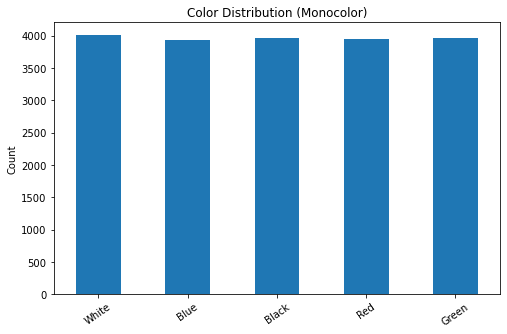

In [54]:
# colors = ['gold', 'blue', 'black', 'red', 'green']
ax = counts.reindex([l for l in 'WUBRG']).plot(kind='bar', figsize=(8, 5))#, color=colors)
ax.set_title('Color Distribution (Monocolor)')
ax.set_xticklabels(['White', 'Blue', 'Black', 'Red', 'Green'])
ax.set_ylabel('Count')
plt.setp(ax.get_xticklabels(), rotation=35, ha='center')
ax.figure.savefig('img/plots/color_dist', facecolor='white')

In [4]:
for i, c in cards[cards['name'] == 'Force of Will'].iterrows():
    print(c['id'])
    print(c['image_uris']['art_crop'])


026983a4-03ca-4812-b129-5ea523596942
https://c1.scryfall.com/file/scryfall-cards/art_crop/front/0/2/026983a4-03ca-4812-b129-5ea523596942.jpg?1562895460
53ed5673-728f-4da3-ad18-3bd72032e815
https://c1.scryfall.com/file/scryfall-cards/art_crop/front/5/3/53ed5673-728f-4da3-ad18-3bd72032e815.jpg?1562258455
9a879b60-4381-447d-8a5a-8e0b6a1d49ca
https://c1.scryfall.com/file/scryfall-cards/art_crop/front/9/a/9a879b60-4381-447d-8a5a-8e0b6a1d49ca.jpg?1562769672
ebc01ab4-d89a-4d25-bf54-6aed33772f4b
https://c1.scryfall.com/file/scryfall-cards/art_crop/front/e/b/ebc01ab4-d89a-4d25-bf54-6aed33772f4b.jpg?1580013954
ec136ce7-bad4-4ebb-ab00-b86de3d209a7
https://c1.scryfall.com/file/scryfall-cards/art_crop/front/e/c/ec136ce7-bad4-4ebb-ab00-b86de3d209a7.jpg?1599710933


In [5]:
def plot_channels(fp, name='Full Color'):
    raw_image = tf.io.read_file(fp)
    image = tf.image.decode_jpeg(raw_image)
    fig, axs = plt.subplots(1, 4, figsize=(10,5))
    axs[0].imshow(image)
    axs[0].set_title(name)
    for i in range(1, 4):
        axs[i].imshow(image[:, :, i-1], cmap=[plt.cm.Reds, plt.cm.Greens, plt.cm.Blues][i-1])
        axs[i].set_title('{} Channel'.format(['Red', 'Green', 'Blue'][i-1]))
    plt.tight_layout()
    fig.savefig(f'img/{name.lower()}_color_brkdwn.png')

In [6]:
sample_cards = [
    '1da67d77-1cbd-4f0e-a109-87fb4c84bcca',
    '7bd03c80-7812-4704-9e07-9cf73b49c01f',
    'e3bb7271-634a-4612-9073-7a5438e8c2b8',
    'c1ba83ab-83f5-421d-bba1-0f925870b5c8',
    'b7b7aa34-b4f8-41b4-82ce-ab2e204c3bf4',
    'a15d33d6-7213-4482-a1be-ac0a73644af6'
]

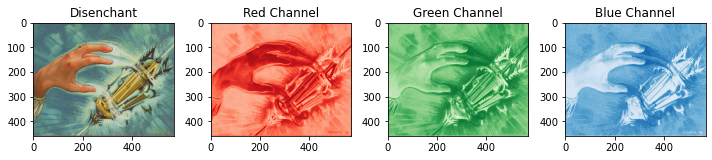

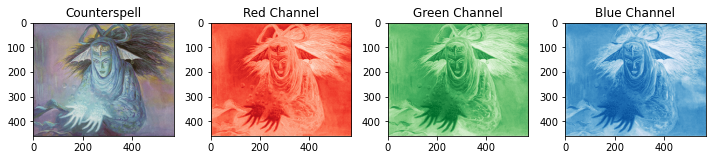

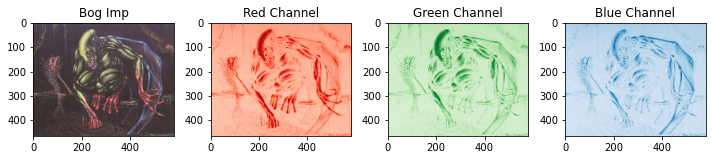

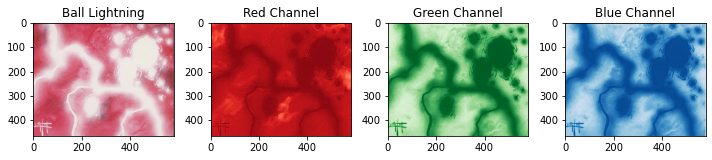

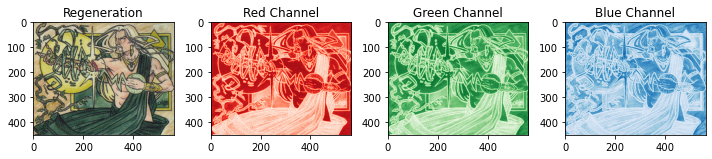

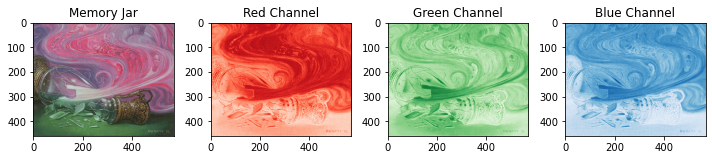

In [7]:
for cid in sample_cards:
    c = cards[cards['id'] == cid]
    fp = f"/home/jovyan/data/art/{c['set'].values[0]}/{cid}.jpg"
    plot_channels(fp, c['name'].values[0])

In [8]:
model_db.update_one({'_id': ObjectId('60863b73da5ff96f06f44d3f')}, {'$set': {'epochs': 50}})

In [55]:
for doc in model_db.find({}):
    if '50 epochs' in doc['note']:
        print(doc['_id'])

60863b73da5ff96f06f44d3f
60875c6051b9665949ef4a72


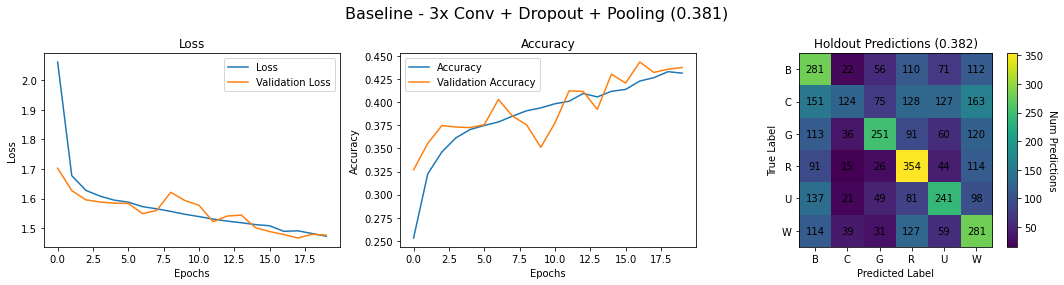

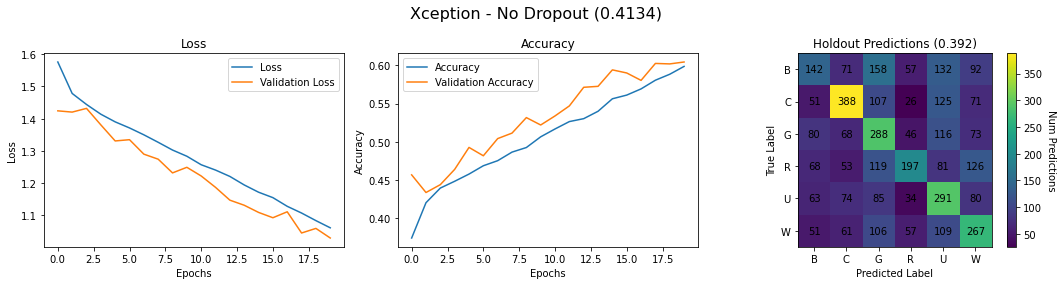

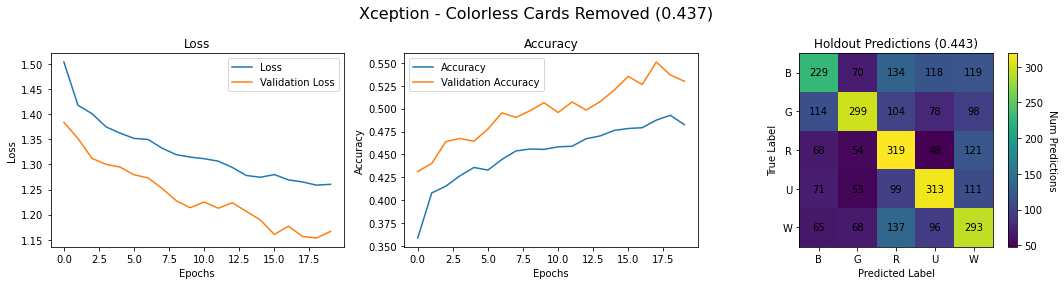

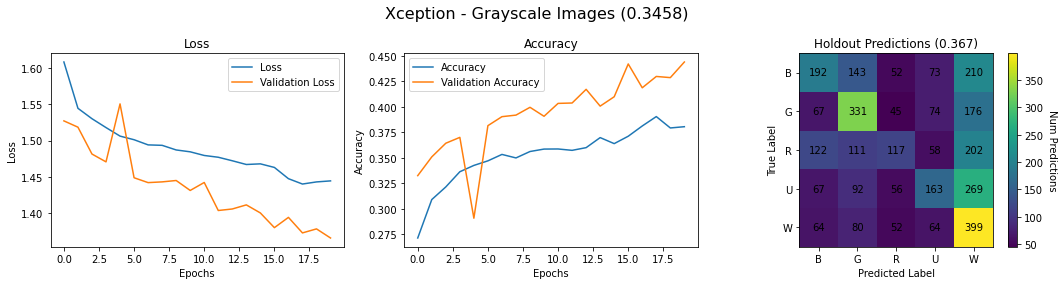

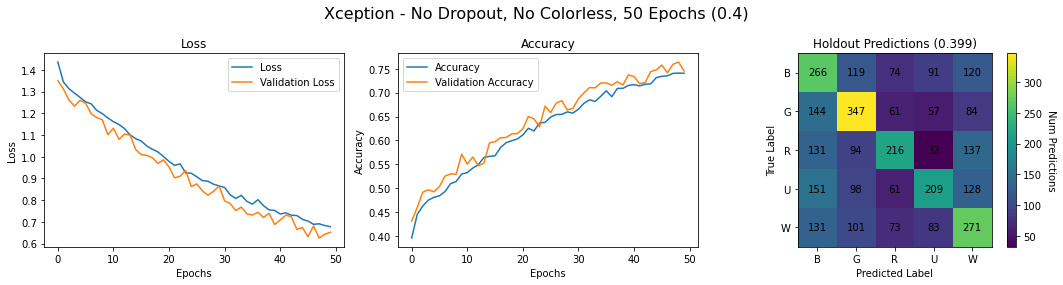

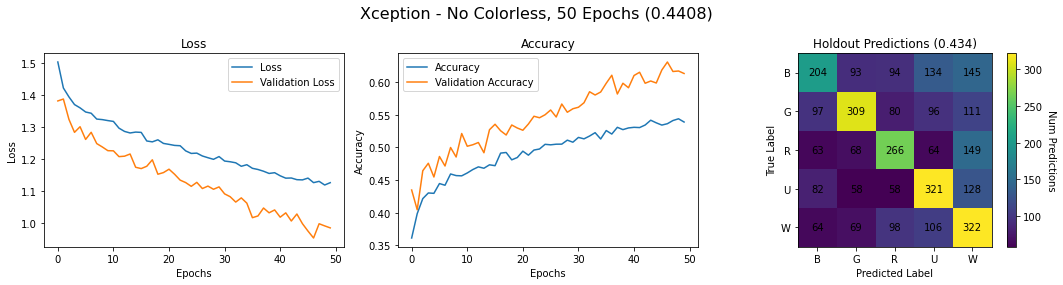

In [62]:
for title, _id  in {
    'Baseline - 3x Conv + Dropout + Pooling': '6083729e817fb8de43dc61df',
#     '60838ba9817fb8de43dc61e0',
#     '6083b0f0817fb8de43dc61e1',
    'Xception - No Dropout': '608470e8e3116d5ffa872c33',
#     '60849f3420c23162ff693652',
#     '6084c5bd96688d52885d50b8',
#     '6084ea226aabc4f5f850ef1a',
    'Xception - Colorless Cards Removed': '608587d4b5d36477fbf317ae',
    'Xception - Grayscale Images': '6085bb1ca39a51d8f11bcd4e',
    'Xception - No Dropout, No Colorless, 50 Epochs': '60863b73da5ff96f06f44d3f',
    'Xception - No Colorless, 50 Epochs': '60875c6051b9665949ef4a72'}.items():
    doc = model_db.find_one({'_id': ObjectId(_id)})
    e = doc['epochs']
    e = range(50 if e == 5 else e)
    df = pd.DataFrame.from_dict(doc['holdout_prediction'])
    p, t = df.prediction, df.true
    
    fig, ax = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle(
        f"{title} ({round(doc['eval_score']['test_accuracy'], 4)})",
        fontsize=16
    )
    
    ax[0].plot(e, doc['history']['loss'], label='Loss')
    ax[0].plot(e, doc['history']['val_loss'], label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss')
    ax[0].legend()
    
    ax[1].plot(e, doc['history']['accuracy'], label='Accuracy')
    ax[1].plot(e, doc['history']['val_accuracy'], label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    
    holdout_acc = round(accuracy_score(t, p), 3)
    plot_conf_matrix(t, p, 
                     labels=doc['class_indices'].keys(),
                     title=f'Holdout Predictions ({holdout_acc})',
                     cbarlabel='Num Predictions',
                     ax=ax[2])
    
    savetitle = title
    for r in '-,+':
        savetitle = savetitle.replace(r, '')
    savetitle = '_'.join(savetitle.split())
    
    fig.savefig(f'img/plots/{savetitle}.png', facecolor='white')
    
    plt.tight_layout()
    plt.show()
    

In [11]:
doc = model_db.find_one({'_id': ObjectId('60863b73da5ff96f06f44d3f')})
model = load_model(doc['model'])

[[1. 0. 0. 0. 0.]]


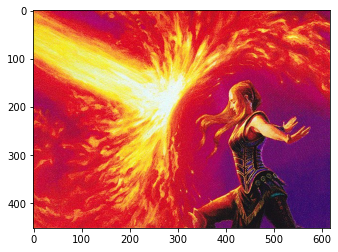

[[0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 1.5849808e-28]]


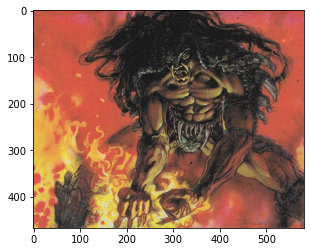

In [21]:
for cid in ['53ed5673-728f-4da3-ad18-3bd72032e815',  # Force of Will new
            '9a879b60-4381-447d-8a5a-8e0b6a1d49ca']:  # Force of Will old
    c = cards[cards['id'] == cid]
    fp = f"/home/jovyan/data/art/{c['set'].values[0]}/{cid}.jpg"
#     plot_channels(fp, c['name'].values[0])
    img = load_img(fp, target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,) + img.shape)
    raw_image = tf.io.read_file(fp)
    image = tf.image.decode_jpeg(raw_image)
    print(model.predict(img))
    plt.imshow(image)
    plt.show()
    

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 21,913,133
Trainable params: 21,858,605
Non-trainable params: 54,528
_________________________________________________________________


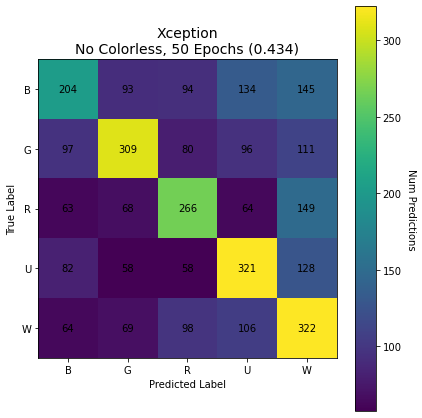

In [58]:
for title, _id  in {
    'Baseline - 3x Conv + Dropout + Pooling': '6083729e817fb8de43dc61df',
#     '60838ba9817fb8de43dc61e0',
#     '6083b0f0817fb8de43dc61e1',
    'Xception - No Dropout': '608470e8e3116d5ffa872c33',
#     '60849f3420c23162ff693652',
#     '6084c5bd96688d52885d50b8',
#     '6084ea226aabc4f5f850ef1a',
    'Xception - Colorless Cards Removed': '608587d4b5d36477fbf317ae',
    'Xception - Grayscale Images': '6085bb1ca39a51d8f11bcd4e',
    'Xception - No Dropout, No Colorless, 50 Epochs': '60863b73da5ff96f06f44d3f'
    'Xception - No Colorless, 50 Epochs': '60875c6051b9665949ef4a72'}.items():
    doc = model_db.find_one({'_id': ObjectId(_id)})
    df = pd.DataFrame.from_dict(doc['holdout_prediction'])
    p, t = df.prediction, df.true
    holdout_acc = round(accuracy_score(t, p), 3)
    
    fig, ax = plt.subplots(figsize=(6,6))
    title = title.replace(' - ', '\n')
    ax.set_title(f"{title} ({holdout_acc})", fontsize=14)
    
    plot_conf_matrix(t, p, 
                     labels=doc['class_indices'].keys(),
                     cbarlabel='Num Predictions',
                     ax=ax)
    
    savetitle = title
    for r in '-,+':
        savetitle = savetitle.replace(r, '')
    savetitle = '_'.join(savetitle.split())
    
    plt.tight_layout()
    fig.savefig(f'img/plots/{savetitle}_conv.png', facecolor='white')
    plt.show()
    